# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [5]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [6]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        # инициализируем экземпляры класса
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
        self.trees = []
        self.gs = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        def loss(gamma, comp_, pred_):
            ssum = comp_ + gamma * pred_
            return ((y - ssum) ** 2).mean()
        
        y_new = y
        comp = 0
        start_g = 0.1
        
        for i in range(self.n_estimators):
            # your code here
            pred = self._fit_predict_tree(x, y_new)
            g = minimize(loss, [start_g], args = (comp, pred)).x[0]
            self.gs.append(g)
            
            comp += g * self.learning_rate * pred
            y_new = -2 * (comp - y) # градиент

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        # your code here
        tree = DecisionTreeRegressor(max_depth = self.max_depth).fit(x, y)
        self.trees.append(tree)
        pred = tree.predict(x)
        return pred 
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = 0
        for i in range(self.n_estimators):
            pred = self.trees[i].predict(x)
            y_pred = y_pred + self.gs[i] * self.learning_rate * pred
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [7]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [8]:
# просмотр данных
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(max_features = 4, n_estimators = 640, random_state = 19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.635844078917064

In [10]:
np.random.seed(19052019)
model = GradientBoostingRegressor()

params ={'max_depth': [7, 8, 10],
         'n_estimators': [200, 300, 400, 500, 600, 700, 800, 1000]}

model_cv = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=3).fit(X_train, y_train)

In [ ]:
np.random.seed(19052019)
model = GradientBoostingRegressor()

params ={'max_depth': [7, 8, 10],
         'n_estimators': [200, 300, 400, 500, 600, 700, 800, 1000]}

model_cv = GridSearchCV(model, params, scoring = 'neg_mean_squared_error', cv = 3).fit(X_train, y_train)

In [ ]:
mean_squared_error(y_test, model_cv.best_estimator_.predict(X_test))

10.379520716020615

In [ ]:
model_cv.best_estimator_

GradientBoostingRegressor(max_depth=7, n_estimators=300)

In [ ]:
np.random.seed(19052019)

# your code here
gb = GradientBoosting(300, 7)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

11.540254831662335

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [8]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size = 0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part) 
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7009988568036374

In [ ]:
# your code here
from sklearn.preprocessing import LabelEncoder

cat_cols = list(set(train.columns) - set(['DepTime', 'Distance']))
train[cat_cols] = train[cat_cols].apply(LabelEncoder().fit_transform)

y_train = train['dep_delayed_15min']
X_train = train.drop('dep_delayed_15min', 1)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [ ]:
model = LGBMClassifier()

params ={'max_depth': [5, 8, 10, 15],
         'n_estimators': [200, 300, 500]}

model_cv = GridSearchCV(model, params, scoring = 'roc_auc', cv = 3).fit(X_train, y_train)

In [ ]:
print('Best max_depth:', model_cv.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model_cv.best_estimator_.get_params()['n_estimators'])

Best max_depth: 5
Best min_samples_split: 500


In [ ]:
model_best = model_cv.best_estimator_

In [ ]:
roc_auc_score(y_valid, model_best.predict_proba(X_valid)[:, 1])

0.8274263091978648

- **Вывод:** с использованием LightGBM и GridSearchCV порог в 0.74 преодолен (0.83)

  Оптимальными подобранными на валидации параметрами оказались: максимальная глубина в качестве критерия остановы = 5 и кол-во деревьев = 500
   

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [45]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [46]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples

        self.cluster = 0

        self.visited = []
        self.clusters = {}
    
    #def map_x(self):
        #return list(map(lambda x: self.clusters[x], self.X))
    
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.X = [(x[0], x[1]) for x in X]
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for i in self.X:
            if i not in self.visited:
                self.visited.append(i)

        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here
                neighbours = self.range_query(i)
        
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here
                if len(neighbours) < self.min_samples:
                    self.clusters[i] = -1

        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
                else:
                    self.grow_cluster(i, neighbours)
                    self.cluster += 1
                    
        return list(map(lambda x: self.clusters[x], self.X))
    

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        self.clusters[root] = self.cluster
        while neighbours:
            q = neighbours[-1]
            del neighbours[-1]

            if q not in self.visited:
                self.visited.append(q)
                q_neighbours = self.range_query(q)
                if len(q_neighbours) >= self.min_samples:
                    neighbours += q_neighbours

            if q not in self.clusters:
                self.clusters[q] = self.cluster
        
    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        points = []
        for i in self.X:
            if self.dist(x, i) < self.eps:
                points.append(i)
        return points

    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        return distance.euclidean(a, b)

Проверим себя на простом примере:

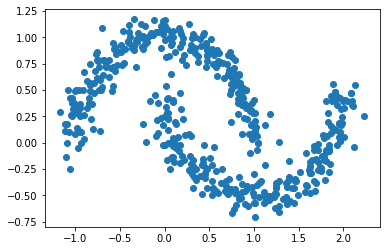

In [7]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

Референс:

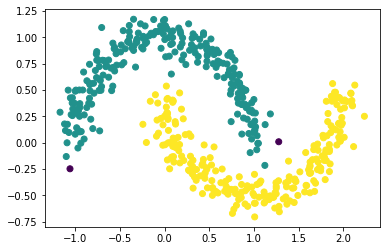

In [8]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.show()

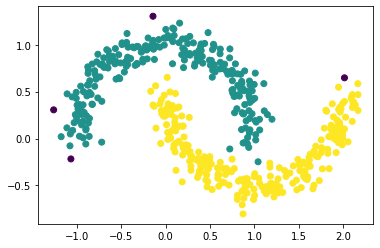

In [ ]:
# your code here
clusters = dbscan(0.2, 10).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



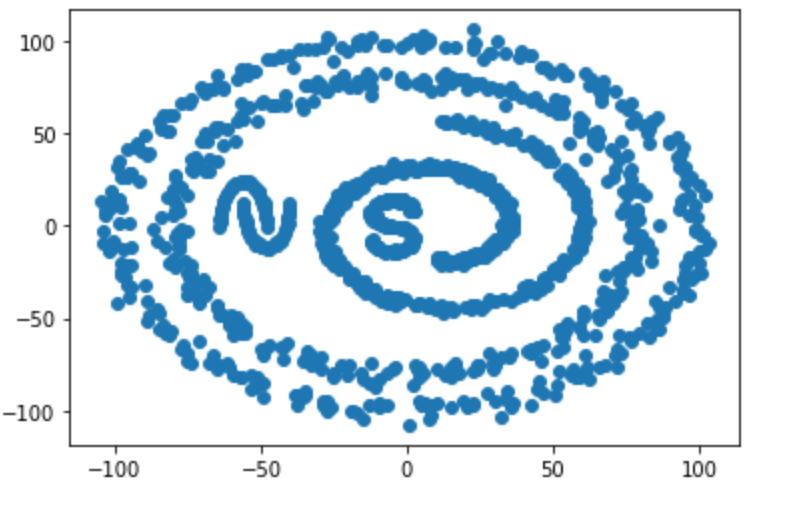


Или хотя бы что-нибудь такое: 

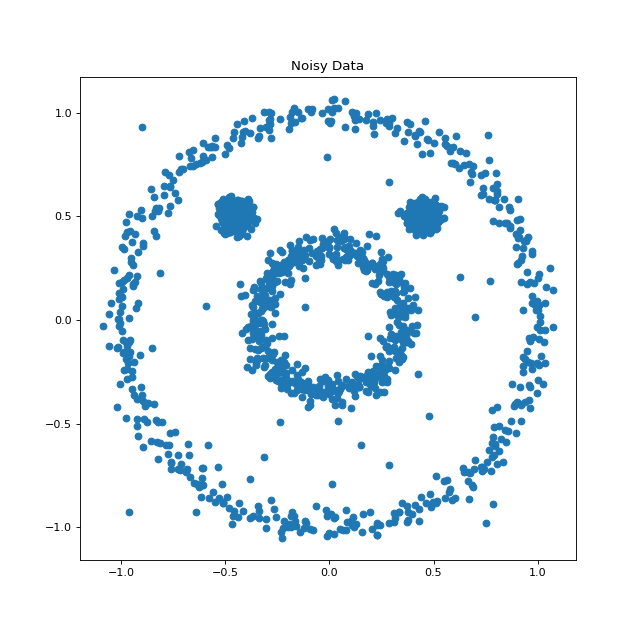

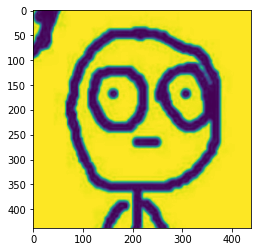

In [ ]:
# your code here
path = 'iad8.jpg'
plt.imshow(plt.imread(path)[..., 0])
plt.show()

In [49]:
img = plt.imread(path)[..., 0]

In [50]:
points = []
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if img[x, y] < 100:
            points.append([x, y])
points = np.array(points[::30])

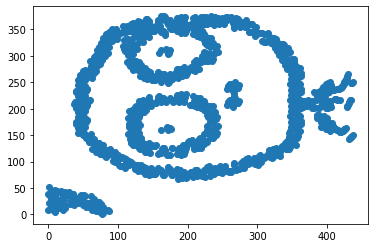

In [ ]:
plt.scatter(np.array(points[::30])[:, 0], np.array(points[::30])[:, 1])
plt.show()

In [51]:
dbscan_model = dbscan(eps=15, min_samples=5)
clusters = dbscan_model.fit_predict(points)

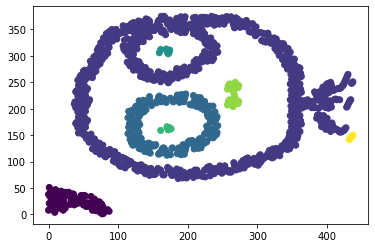

In [ ]:
plt.scatter(points[:,0], points[:,1], c=clusters)
plt.show()

In [ ]:
# сравним в референсной моделью
dbscan_model = DBSCAN(eps=15, min_samples=5)
clusters = dbscan_model.fit_predict(points)

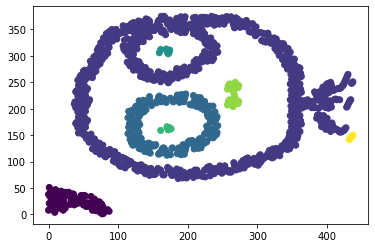

In [ ]:
plt.scatter(points[:,0], points[:,1], c=clusters)
plt.show()

- **Вывод:** сработало идентично.

In [54]:
# кластеры и количество объектов в них
unique, counts = np.unique(clusters, return_counts=True)
np.column_stack((unique, counts))

array([[  0,  93],
       [  1, 949],
       [  2, 217],
       [  3,   8],
       [  4,   7],
       [  5,  32],
       [  6,   6]])

In [56]:
print('Количество кластеров: {}, количество шуммовых точек: 0'.format((len(np.column_stack((unique, counts))))))

Количество кластеров: 7, количество шуммовых точек: 0


- **Вывод:** шумовых точек нет, все распределили на кластеры.


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 9.55 ms, sys: 7.08 ms, total: 16.6 ms
Wall time: 13.8 ms


In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=100000).fit_predict(X)

CPU times: user 1.13 s, sys: 8.14 ms, total: 1.14 s
Wall time: 1.14 s


- **Вывод:** построенная модель сработала не медленнее чем в 100 от референсной.

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [9]:
# your code here  ლ(ಠ益ಠლ)
X = train[['Distance', 'DepTime']].values

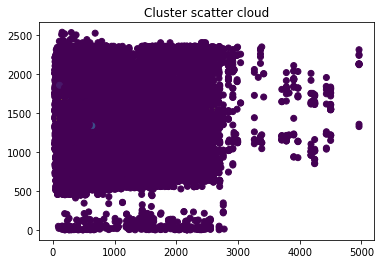

In [10]:
clusters = DBSCAN().fit_predict(X)
plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('Cluster scatter cloud')
plt.show()

In [ ]:
# кластеры и количество объектов в них
unique, counts = np.unique(clusters, return_counts=True)
np.column_stack((unique, counts))[:10]

array([[   -1, 99300],
       [    0,     5],
       [    1,     5],
       [    2,     5],
       [    3,     6],
       [    4,     5],
       [    5,     5],
       [    6,     5],
       [    7,     5],
       [    8,     6]])

In [ ]:
print('Количество кластеров: {}, количество шуммовых точек: {}'.format((len(np.column_stack((unique, counts)))), 
                                                               np.column_stack((unique, counts))[0, 1]))

Количество кластеров: 127, количество шуммовых точек: 99300


- **Вывод:** всего у нас 127 кластеров (включая шум). Шумовых точек получилось слишком много (99300 из 10000), остальные раскиданы по маленьким кластерам – данный алгоритм не очень хороший.

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

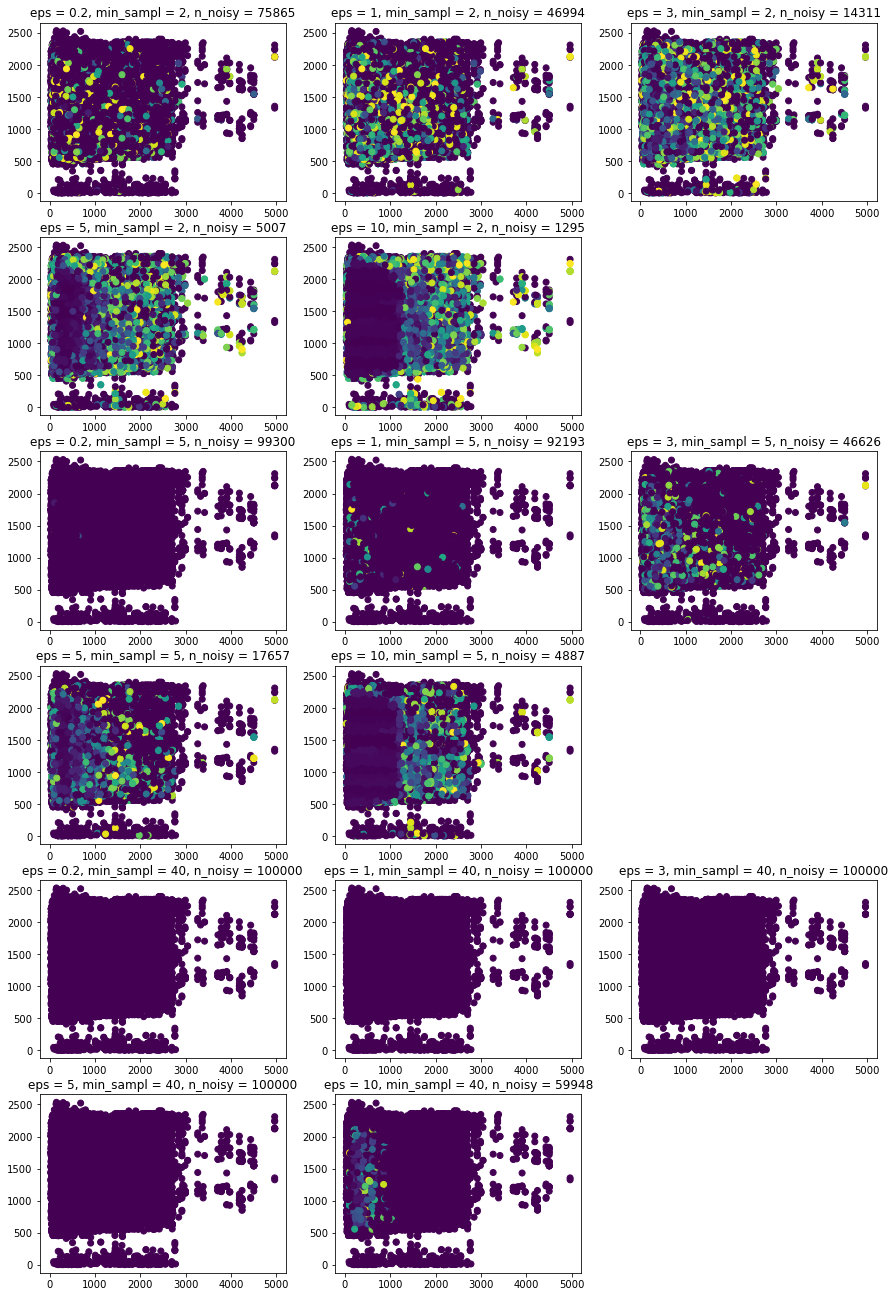

In [ ]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆

plt.figure(figsize= (15,23))
i = 1
for samples in [2, 5, 40]:
    for e in [0.2, 1, 3, 5, 10]:
        dbscan = DBSCAN(eps = e, min_samples = samples)
        clusters = dbscan.fit_predict(X) # X – от train 
        n_noisy = sum(clusters == -1) # количество шумовых точек
        plt.subplot(6, 3, i)
        plt.scatter(X[:,0], X[:,1], c = clusters)
        plt.title('eps = {}, min_sampl = {}, n_noisy = {}'.format(e, samples, n_noisy))
        i += 1
    i+=1

plt.show()

- **Вывод:** по графикам облаков рассеивания видно, что при `min_samples` = 40 (самом большом из имеющихся) и сколь угодно малым `eps` наш алгорим справляется хуже всего (не находит ни одного кластера, все 100 000 объектов – шум). Это связано с тем, что DBSCAN – алгоритм на основе плотности и с меньшей вероятностью найдет точку, в окрестность которой попадает 40 граничных точек для того, чтобы сделать из них (из 2-х) кластер. Таким образом, он причесляет их всех к шуму (точкам, в окрестности которых не хватает заданного минимального числа граничных точек, но есть основная).

    Исходя из полученных выше данных, оптимальные мараметры `min_samples` = 5 и `eps` = 10 с минимальным значением шума = 1245 (1,2%).

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [37]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [39]:
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [41]:
# your code here  ¯\_(ツ)_/¯
dbscan = DBSCAN(eps = 10, min_samples = 5)
clusters = dbscan.fit_predict(X_train)

In [ ]:
!pip install catboost

In [42]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train, verbose = False)
roc_auc_score(y_valid, model_cat.predict_proba(X_valid)[:, 1])

0.7292269936686889

In [43]:
# добоавление признака кластера
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train = pd.DataFrame(X_train)
new_col = pd.DataFrame(clusters)
X_train['new_col'] = new_col.astype('object')
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size = 0.3)

In [44]:
model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train, verbose = False)
roc_auc_score(y_valid, model_cat.predict_proba(X_valid)[:, 1])

0.7433538526771206

__Ответ:__ качество модели улучшилось, так как мы выбрали самый оптимальный алгоритм кластеризации и добавили готовые категории.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

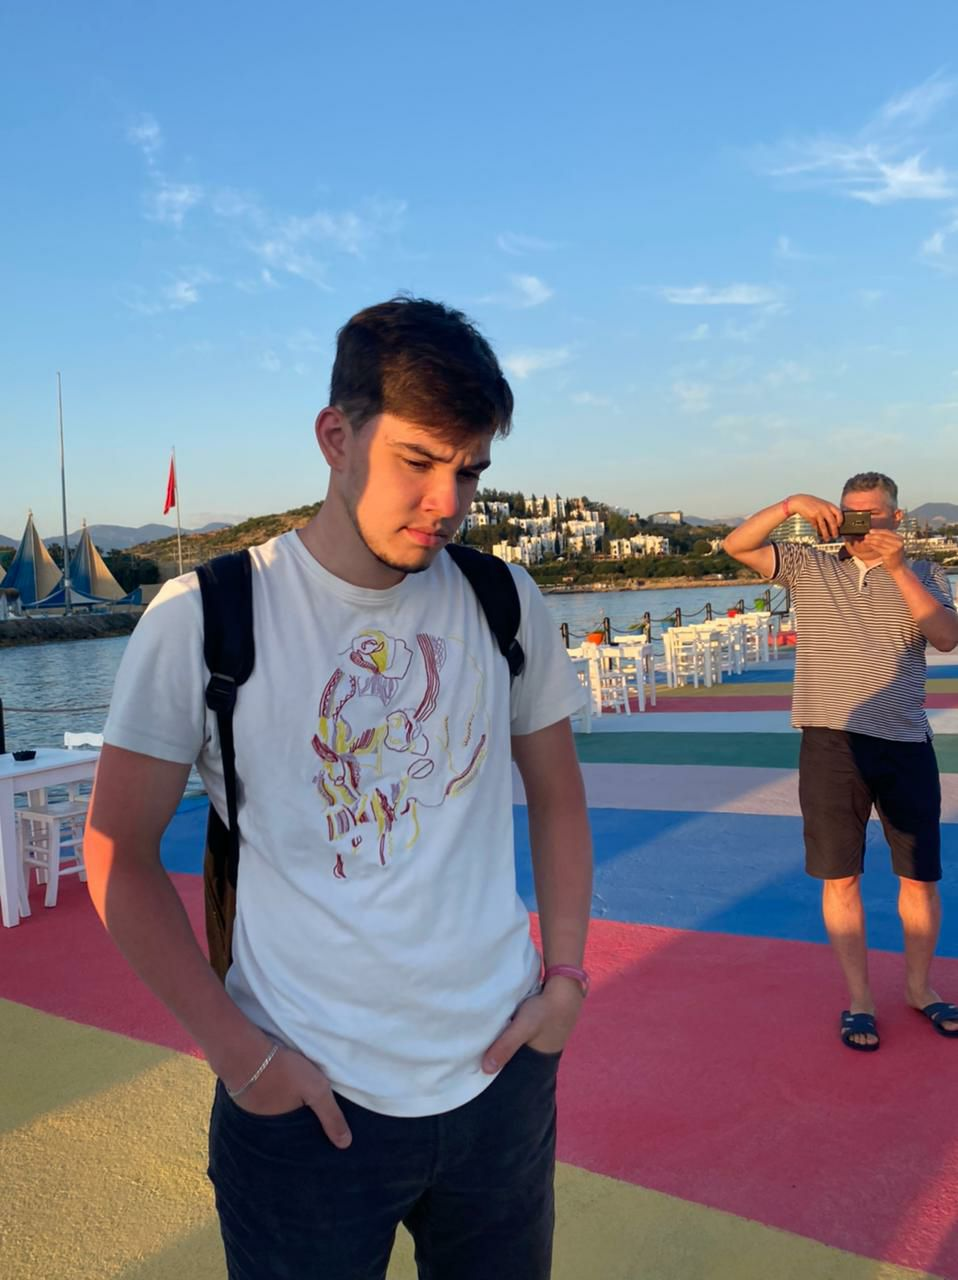

**+0.1 балла** за смешной мем по машинному обучению

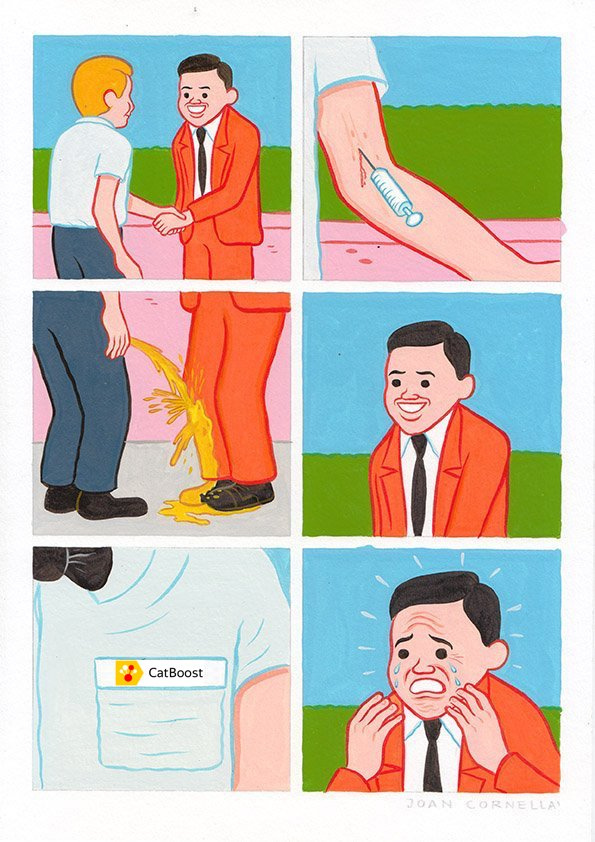

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

- **Вывод о курсе:** вот и преодолен на курс. Во-первых, хочу сказать, что он оказался достаточно сложным. Последние темы брали сутки на понимание, но дарили что-то большее. В общем было сложно, мне понравилось.

- **Благодарность:** админ!! Спасибо тебе большое, что отвечал на мои тупые вопросы. Очень респектую, что отвечал даже поздно вечером. Также хочу сказать супер спасибо семинаристу Роману группы БИ-1 за классные объяснения и непринужденную обстановку занятий. У вас получилось пробудить интерес к дисциплине. Также хочу поблагодарить львиного тигра, тигриного льва в области машинного обучения Евгения Соколова. Это первый предмет, по которому я посмотрел все лекции дважды или мб трижды. В общем вы ребят легенды. Спасибо!

- **Фидбек:** Попробуйте пж раскидать последние темы на большее кол-во занятий и домашек. Их освоение будет проще и погружение будет  мягче. Лог регрессия еще была изи как оказалось на бустинге. Пришлось посмотреть все лекции по раза 3-4, читать статьи. Но это того стоило. 
